<a href="https://colab.research.google.com/github/adong-hood/dm-24/blob/main/module_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 6: Classification

The following tutorial contains Python examples for solving classification problems. You should refer to the Chapters 3 and 4 of the "Introduction to Data Mining" book to understand some of the concepts introduced in this tutorial. The notebook can be downloaded from http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial6/tutorial6.ipynb.

Classification is the task of predicting a nominal-valued attribute (known as class label) based on the values of other attributes (known as predictor variables). The goals for this tutorial are as follows:
1. To provide examples of using different classification techniques from the scikit-learn library package.
2. To demonstrate the problem of model overfitting.

Read the step-by-step instructions below carefully. To execute the code, click on the corresponding cell and press the SHIFT-ENTER keys simultaneously.


In [ ]:
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


%matplotlib inline

## 6.1 Vertebrate Dataset

We use a variation of the vertebrate data described in Example 3.1 of Chapter 3. Each vertebrate is classified into one of 5 categories: mammals, reptiles, birds, fishes, and amphibians, based on a set of explanatory attributes (predictor variables). Except for "name", the rest of the attributes have been converted into a *one hot encoding* binary representation. To illustrate this, we will first load the data into a Pandas DataFrame object and display its content.

In [ ]:
data = pd.read_csv('http://pluto.hood.edu/~dong/datasets/vertebrate.csv',header='infer')
data.head()

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians


Given the limited number of training examples, suppose we convert the problem into a binary classification task (mammals versus non-mammals). We can do so by replacing the class labels of the instances to *non-mammals* except for those that belong to the *mammals* class.

In [ ]:
data['Class'] = data['Class'].replace(['fishes','birds','amphibians','reptiles'],'non-mammals')
data.head()

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,non-mammals
2,salmon,0,0,1,0,0,0,non-mammals
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,non-mammals


We can apply Pandas cross-tabulation to examine the relationship between the Warm-blooded and Gives Birth attributes with respect to the class.

In [ ]:
pd.crosstab([data['Warm-blooded'],data['Gives Birth']],data['Class'])

Class                     mammals  non-mammals
Warm-blooded Gives Birth                      
0            0                  0            7
             1                  0            1
1            0                  0            2
             1                  5            0

The results above show that it is possible to distinguish mammals from non-mammals using these two attributes alone since each combination of their attribute values would yield only instances that belong to the same class. For example, mammals can be identified as warm-blooded vertebrates that give birth to their young. Such a relationship can also be derived using a decision tree classifier, as shown by the example given in the next subsection.

## 6.2 Decision Tree Classifier

In this section, we apply a decision tree classifier to the vertebrate dataset described in the previous subsection.

In [ ]:


Y = data['Class']
X = data.drop(['Name','Class'],axis=1)

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
clf = clf.fit(X, Y)

In [ ]:
feature_importance = clf.feature_importances_
feature_names = X.columns
for feature, importance in sorted(zip(feature_names, feature_importance), key = lambda x: x[1], reverse = True):
  print(f"{feature}:{importance:.2f}")

Gives Birth:0.72
Warm-blooded:0.28
Aquatic Creature:0.00
Aerial Creature:0.00
Has Legs:0.00
Hibernates:0.00


The preceding commands will extract the predictor (X) and target class (Y) attributes from the vertebrate dataset and create a decision tree classifier object using entropy as its impurity measure for splitting criterion. The decision tree class in Python sklearn library also supports using 'gini' as impurity measure. The classifier above is also constrained to generate trees with a maximum depth equals to 3. Next, the classifier is trained on the labeled data using the fit() function.

We can plot the resulting decision tree obtained after training the classifier. To do this, you must first install both graphviz (http://www.graphviz.org) and its Python interface called pydotplus (http://pydotplus.readthedocs.io/).

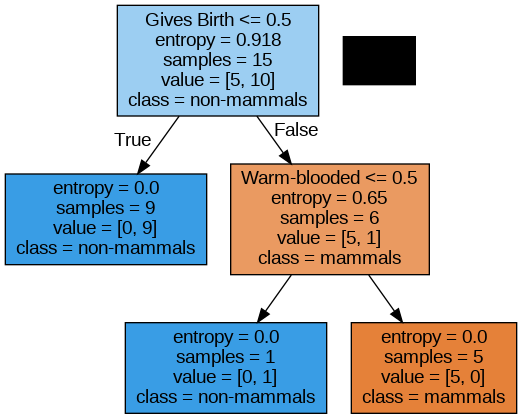

In [ ]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(clf, feature_names=X.columns, class_names=['mammals','non-mammals'], filled=True,
                                out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Next, suppose we apply the decision tree to classify the following test examples.

In [ ]:
testData = [['gila monster',0,0,0,0,1,1,'non-mammals'],
           ['platypus',1,0,0,0,1,1,'mammals'],
           ['owl',1,0,0,1,1,0,'non-mammals'],
           ['dolphin',1,1,1,0,0,0,'mammals']]
testData = pd.DataFrame(testData, columns=data.columns)
testData

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,gila monster,0,0,0,0,1,1,non-mammals
1,platypus,1,0,0,0,1,1,mammals
2,owl,1,0,0,1,1,0,non-mammals
3,dolphin,1,1,1,0,0,0,mammals


We first extract the predictor and target class attributes from the test data and then apply the decision tree classifier to predict their classes.

In [ ]:
testY = testData['Class']
testX = testData.drop(['Name','Class'],axis=1)

predY = clf.predict(testX)
predictions = pd.concat([testData['Name'],pd.Series(predY,name='Predicted Class')], axis=1)
predictions

,Name,Predicted Class
0,gila monster,non-mammals
1,platypus,non-mammals
2,owl,non-mammals
3,dolphin,mammals


Except for platypus, which is an egg-laying mammal, the classifier correctly predicts the class label of the test examples. We can calculate the accuracy of the classifier on the test data as shown by the example given below.

In [ ]:
print('Accuracy on test data is %.2f' % (accuracy_score(testY, predY)))

Accuracy on test data is 0.75


## 6.3 Model Overfitting

To illustrate the problem of model overfitting, we consider a two-dimensional dataset containing 1500 labeled instances, each of which is assigned to one of two classes, 0 or 1. Instances from each class are generated as follows:
1. Instances from class 1 are generated from a mixture of 3 Gaussian distributions, centered at [6,14], [10,6], and [14 14], respectively.
2. Instances from class 0 are generated from a uniform distribution in a square region, whose sides have a length equals to 20.

For simplicity, both classes have equal number of labeled instances. The code for generating and plotting the data is shown below. All instances from class 1 are shown in red while those from class 0 are shown in black.

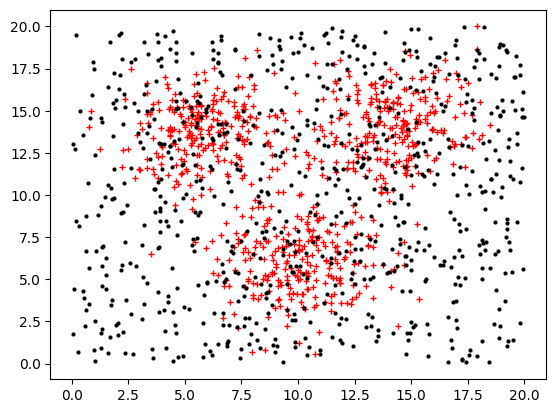

In [ ]:

N = 1500

mean1 = [6, 14]
mean2 = [10, 6]
mean3 = [14, 14]
cov = [[3.5, 0], [0, 3.5]]  # diagonal covariance

np.random.seed(50)
X = np.random.multivariate_normal(mean1, cov, int(N/6))
X = np.concatenate((X, np.random.multivariate_normal(mean2, cov, int(N/6))))
X = np.concatenate((X, np.random.multivariate_normal(mean3, cov, int(N/6))))
X = np.concatenate((X, 20*np.random.rand(int(N/2),2)))
Y = np.concatenate((np.ones(int(N/2)),np.zeros(int(N/2))))

plt.plot(X[:int(N/2),0],X[:int(N/2),1],'r+',X[int(N/2):,0],X[int(N/2):,1],'k.',ms=4)

In this example, we reserve 80% of the labeled data for training and the remaining 20% for testing. We then fit decision trees of different maximum depths (from 2 to 50) to the training set and plot their respective accuracies when applied to the training and test sets.

Text(0, 0.5, 'Accuracy')

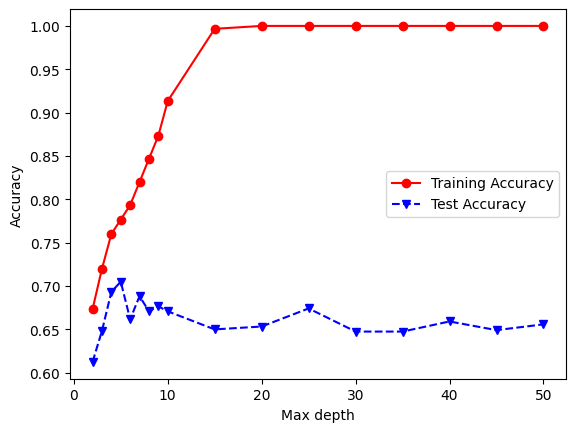

In [ ]:
#########################################
# Training and Test set creation
#########################################

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=1)


#########################################
# Model fitting and evaluation
#########################################

maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]

trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

#########################################
# Plot of training and test accuracies
#########################################

plt.plot(maxdepths,trainAcc,'ro-',maxdepths,testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

The plot above shows that training accuracy will continue to improve as the maximum depth of the tree increases (i.e., as the model becomes more complex). However, the test accuracy initially improves up to a maximum depth of 5, before it gradually decreases due to model overfitting.

## 6.4 Alternative Classification Techniques

Besides decision tree classifier, the Python sklearn library also supports other classification techniques. In this section, we provide examples to illustrate how to apply the k-nearest neighbor classifier, linear classifiers (logistic regression and support vector machine), as well as ensemble methods (boosting, bagging, and random forest) to the 2-dimensional data given in the previous section.

### 6.4.4 Ensemble Methods

An ensemble classifier constructs a set of base classifiers from the training data and performs classification by taking a vote on the predictions made by each base classifier. We consider 3 types of ensemble classifiers in this example: bagging, boosting, and random forest. Detailed explanation about these classifiers can be found in Section 4.10 of the book.

In the example below, we fit 500 base classifiers to the 2-dimensional dataset using each ensemble method. The base classifier corresponds to a decision tree with maximum depth equals to 10.

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']

data = data.drop(['Sample code'],axis=1)
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 699
Number of attributes = 10


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [ ]:
data = data.replace('?',np.nan)
# Convert 'Bare Nuclei' column to numeric, errors='coerce' will handle invalid parsing as NaN
data['Bare Nuclei'] = pd.to_numeric(data['Bare Nuclei'], errors='coerce')
data.fillna(data.median(), inplace=True)

Y = data['Class']
X = data.drop(['Class'],axis=1)

#########################################
# Training and Test set creation
#########################################

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


Results

Random Forest Train = 1.00; Test = 0.98
Bagging Train = 1.00; Test = 0.95
AdaBoost Train = 1.00; Test = 0.91



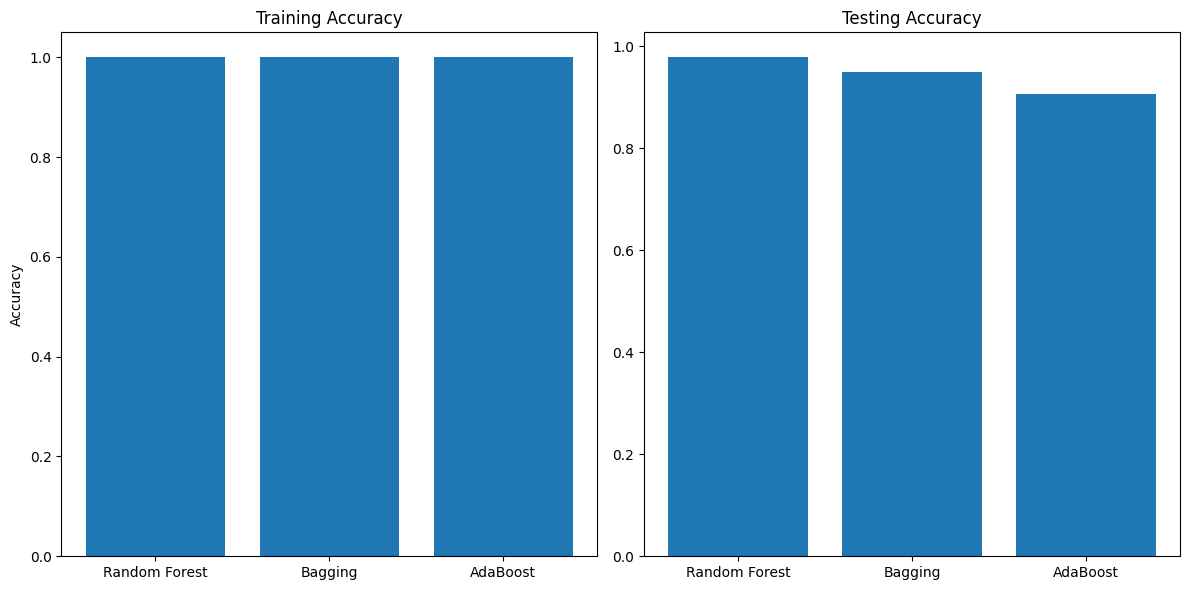

In [ ]:
## You could create a function here for  using multiple algorithms.
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier

numBaseClassifiers = 100
maxdepth = 10
trainAcc = []
testAcc = []

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers, algorithm='SAMME')
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

print("Results\n")
print('Random Forest Train = %.2f; Test = %.2f'%(trainAcc[0],testAcc[0]))
print('Bagging Train = %.2f; Test = %.2f' %(trainAcc[1],testAcc[1]))
print('AdaBoost Train = %.2f; Test = %.2f\n' %(trainAcc[2],testAcc[2]))


methods = ['Random Forest', 'Bagging', 'AdaBoost']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.bar([1.5,2.5,3.5], trainAcc)
ax1.set_xticks([1.5,2.5,3.5])
ax1.set_xticklabels(methods)
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')

ax2.bar([1.5,2.5,3.5], testAcc)
ax2.set_xticks([1.5,2.5,3.5])
ax2.set_xticklabels(methods)
ax2.set_title('Testing Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# this shows a simple majority voting.
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, Y_train)
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
 clf.fit(X_train, Y_train)
 y_pred = clf.predict(X_test)
 print(clf.__class__.__name__, accuracy_score(Y_test, y_pred))

LogisticRegression 0.9785714285714285
RandomForestClassifier 0.9571428571428572
SVC 0.9785714285714285
VotingClassifier 0.9785714285714285


### 6.4.1 K-Nearest neighbor classifier

In this approach, the class label of a test instance is predicted based on the majority class of its *k* closest training instances. The number of nearest neighbors, *k*, is a hyperparameter that must be provided by the user, along with the distance metric. By default, we can use Euclidean distance (which is equivalent to Minkowski distance with an exponent factor equals to p=2):

\begin{equation*}
\textrm{Minkowski distance}(x,y) = \bigg[\sum_{i=1}^N |x_i-y_i|^p \bigg]^{\frac{1}{p}}
\end{equation*}

Text(0, 0.5, 'Accuracy')

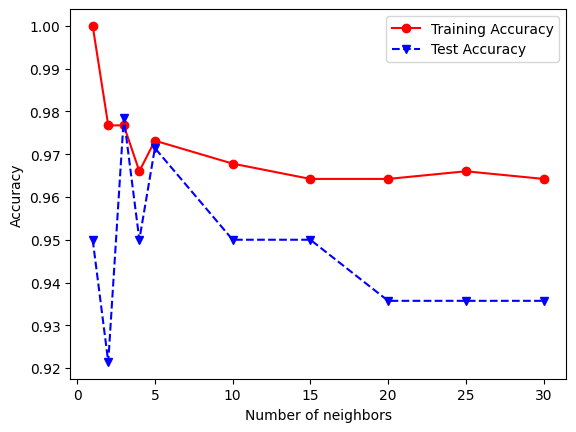

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


numNeighbors = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]
trainAcc = []
testAcc = []

for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    trainAcc.append(accuracy_score(Y_train, Y_predTrain))
    testAcc.append(accuracy_score(Y_test, Y_predTest))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

### 6.4.2 Linear Classifiers

Linear classifiers such as logistic regression and support vector machine (SVM) constructs a linear separating hyperplane to distinguish instances from different classes.

For logistic regression, the model can be described by the following equation:
\begin{equation*}
P(y=1|x) = \frac{1}{1 + \exp^{-w^Tx - b}} = \sigma(w^Tx + b)
\end{equation*}
The model parameters (w,b) are estimated by optimizing the following regularized negative log-likelihood function:
\begin{equation*}
(w^*,b^*) = \arg\min_{w,b} - \sum_{i=1}^N y_i \log\bigg[\sigma(w^Tx_i + b)\bigg] + (1-y_i) \log\bigg[\sigma(-w^Tx_i - b)\bigg] + \frac{1}{C} \Omega([w,b])
\end{equation*}
where $C$ is a hyperparameter that controls the inverse of model complexity (smaller values imply stronger regularization) while $\Omega(\cdot)$ is the regularization term, which by default, is assumed to be an $l_2$-norm in sklearn.

For support vector machine, the model parameters $(w^*,b^*)$ are estimated by solving the following constrained optimization problem:
\begin{eqnarray*}
&&\min_{w^*,b^*,\{\xi_i\}} \frac{\|w\|^2}{2} + \frac{1}{C} \sum_i \xi_i \\
\textrm{s.t.} && \forall i: y_i\bigg[w^T \phi(x_i) + b\bigg] \ge 1 - \xi_i, \ \ \xi_i \ge 0  
\end{eqnarray*}

Text(0, 0.5, 'Accuracy')

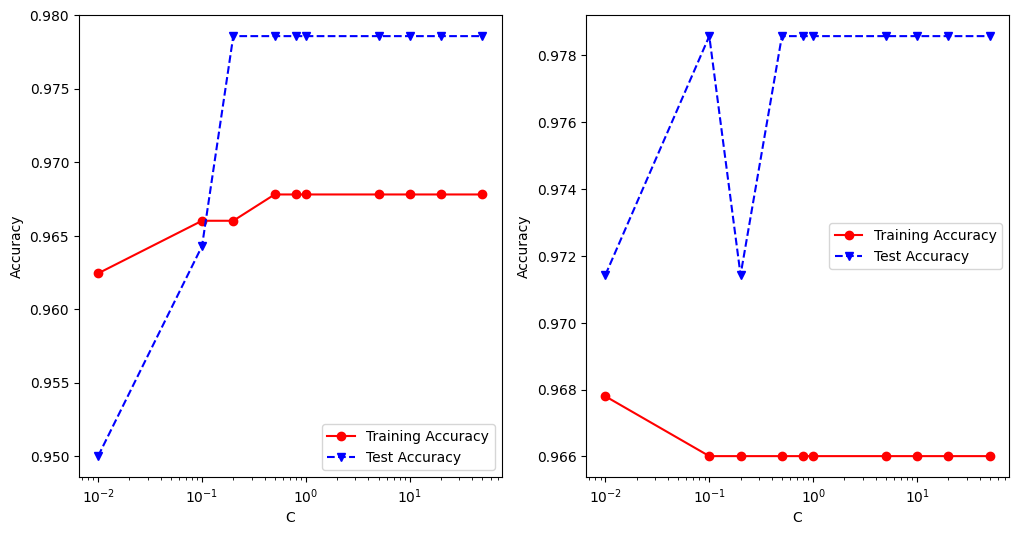

In [ ]:
from sklearn import linear_model
from sklearn.svm import SVC

C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
LRtrainAcc = []
LRtestAcc = []
SVMtrainAcc = []
SVMtestAcc = []

for param in C:
    clf = linear_model.LogisticRegression(C=param)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    LRtrainAcc.append(accuracy_score(Y_train, Y_predTrain))
    LRtestAcc.append(accuracy_score(Y_test, Y_predTest))

    clf = SVC(C=param,kernel='linear')
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    SVMtrainAcc.append(accuracy_score(Y_train, Y_predTrain))
    SVMtestAcc.append(accuracy_score(Y_test, Y_predTest))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(C, LRtrainAcc, 'ro-', C, LRtestAcc,'bv--')
ax1.legend(['Training Accuracy','Test Accuracy'])
ax1.set_xlabel('C')
ax1.set_xscale('log')
ax1.set_ylabel('Accuracy')

ax2.plot(C, SVMtrainAcc, 'ro-', C, SVMtestAcc,'bv--')
ax2.legend(['Training Accuracy','Test Accuracy'])
ax2.set_xlabel('C')
ax2.set_xscale('log')
ax2.set_ylabel('Accuracy')

In [ ]:
# this shows using GridSearch for model hyperparameters.

from sklearn.model_selection import GridSearchCV

params = {'C': [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]}
grid = GridSearchCV(linear_model.LogisticRegression(), params, cv = 5)
grid.fit(X_train, Y_train)

for param, score in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
  print(param, score)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test, Y_test)))
print("Best parameters: ", grid.best_params_)

{'C': 0.01} 0.9641731016731017
{'C': 0.1} 0.9606016731016732
{'C': 0.2} 0.9606016731016732
{'C': 0.5} 0.9623873873873874
{'C': 0.8} 0.9623873873873874
{'C': 1} 0.9623873873873874
{'C': 5} 0.9623873873873874
{'C': 10} 0.9623873873873874
{'C': 20} 0.9623873873873874
{'C': 50} 0.9623873873873874
Best cross-validation accuracy: 0.96
Best set score: 0.95
Best parameters:  {'C': 0.01}


In [ ]:
# Example of cross-vaidation.

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

lr = linear_model.LogisticRegression(C=0.01)
scores = cross_val_score(lr, X, Y, cv=5, scoring = 'f1_macro')
print("Cross-validation scores: {}".format(scores))

cv_ = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
scores = cross_val_score(lr, X, Y, cv=cv_, scoring = 'roc_auc_ovr_weighted')
print("Cross-validation scores: {}".format(scores))



Cross-validation scores: [0.88399621 0.9383124  0.98414855 0.97610242 0.98392692]
Cross-validation scores: [0.99818841 0.99071558 0.99275362 0.99686028 0.99473443 0.99750906
 0.99705616 0.99320652 0.99730881 0.99175824 0.99026268 0.99841486
 0.99592391 0.99798161 0.98992674]


Note that linear classifiers perform poorly on the data since the true decision boundaries between classes are nonlinear for the given 2-dimensional dataset.

### 6.4.3 Nonlinear Support Vector Machine

The code below shows an example of using nonlinear support vector machine with a Gaussian radial basis function kernel to fit the 2-dimensional dataset.

Text(0, 0.5, 'Accuracy')

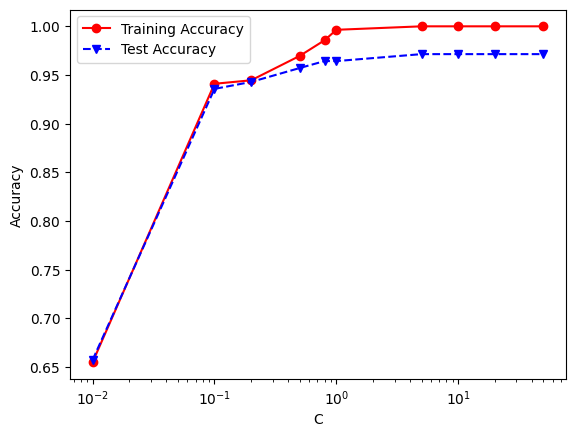

In [ ]:
from sklearn.svm import SVC

C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
SVMtrainAcc = []
SVMtestAcc = []

for param in C:
    clf = SVC(C=param,kernel='rbf',gamma='auto')
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    SVMtrainAcc.append(accuracy_score(Y_train, Y_predTrain))
    SVMtestAcc.append(accuracy_score(Y_test, Y_predTest))

plt.plot(C, SVMtrainAcc, 'ro-', C, SVMtestAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')

Observe that the nonlinear SVM can achieve a higher test accuracy compared to linear SVM.

## 3.5 Summary

This section provides several examples of using Python sklearn library to build classification models from a given input data. We also illustrate the problem of model overfitting and show how to apply different classification methods to the given dataset.

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

# variable information
print(iris.variables)


           name     role         type demographic  \
0  sepal length  Feature   Continuous        None   
1   sepal width  Feature   Continuous        None   
2  petal length  Feature   Continuous        None   
3   petal width  Feature   Continuous        None   
4         class   Target  Categorical        None   

                                         description units missing_values  
0                                               None    cm             no  
1                                               None    cm             no  
2                                               None    cm             no  
3                                               None    cm             no  
4  class of iris plant: Iris Setosa, Iris Versico...  None             no  


In [ ]:
X.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
y.head()

,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa


# Homework 4 #

The goal of this is to use a Machine Learning package in Python called sklearn. The best resource for learning sklearn is its documentation found at https://scikit-learn.org/stable/.

You may work in a group of 2. Your Homework 4 submission should only include content from this point on. pdf, not ipynb.

Pick one of the two datasets for this homewrok: iris dataset (https://archive.ics.uci.edu/dataset/53/iris) **or** OSA (http://pluto.hood.edu/~dong/datasets/osa_hf_all_features_labeled_processed_2.csv, about 174M. Please copy the url to your browser directly for downloading the dataset.). Your task is build and compare different classification algorithms introduced in this class.

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/datamining/osa_hf_all_features_labeled_processed_2.csv')
# print(data.shape)
# data.head(1)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datamining/osa_hf_all_features_labeled_processed_2.csv'

In [ ]:
data['group'].value_counts()

### Requirements and questions ###
**Exploratory Analysis**(10 points)
<ul>
<li>Are three any correlation between features? why or why not? </li>
<li>Are there any outliers in the dataset? why or why not? </li>
<li>Are there any normalization needed? why or why not?</li>
<li>Are there any missing values? Why or why not?</li>
</ul>

**Classification** (25 points)
<ul>
<li>Experiment the following algorithms/models: decision tree, random forest, adaboost, KNN, SVM, MLP, and Naive Baye</li>
<Li>For each model, train-test-split with 80% for train and 20% for test.</li>
<li>For each algorithm, output the following performance measures: accuracy, precision, and recall</li>
</ul>


**Visualization** (5 points)

Pick at least one visualization for model perfomnace comparison.

**Reflection** (15 points)
<ul>
<li>What is the best K in KNN? Only consider k in the range of 1-15. Use odd numbers only.</li>
<li>What is the most important features found by decision tree and random forest? </li>
<li>Which algorithm has the highest accuracy? Is there model overfitting for this algorithm? Why or why not?Perform 10-fold cross-validation with this algorithm and report the accuracy, precision and recall. </li>
</ul>

In [ ]:
#pasted from URL
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

# metadata
print(iris.metadata)

# variable information
print(iris.variables)


{'uci_id': 53, 'name': 'Iris', 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris', 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv', 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 150, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1936, 'last_updated': 'Tue Sep 12 2023', 'dataset_doi': '10.24432/C56C76', 'creators': ['R. A. Fisher'], 'intro_paper': {'ID': 191, 'type': 'NATIVE', 'title': 'The Iris data set: In search of the source of virginica', 'authors': 'A. Unwin, K. Kleinman', 'venue': 'Significance, 2021', 'year': 2021, 'journal': 'Significance, 2021', 'DOI': '1740-9713.01589', 'URL': 'https://www.semanticscholar.org

In [ ]:
correlation_matrix = X.corr(method='pearson')
print(correlation_matrix)

#yes there is a strong correlation between the pedal length

              sepal length  sepal width  petal length  petal width
sepal length      1.000000    -0.109369      0.871754     0.817954
sepal width      -0.109369     1.000000     -0.420516    -0.356544
petal length      0.871754    -0.420516      1.000000     0.962757
petal width       0.817954    -0.356544      0.962757     1.000000


In [ ]:
import numpy as np

z_scores = np.abs((X - X.mean()) / X.std())
outliers = (z_scores > 3).any(axis=1)
print(X[outliers])
print("num of outliers:", outliers.sum())

#there is one outlier present this was found ing z_score to detmine the outlier.

    sepal length  sepal width  petal length  petal width
15           5.7          4.4           1.5          0.4
num of outliers: 1


In [ ]:
# check for missing vals
dups = X.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

# yes we have 3 duplicate rows found in hte X set the .duplicated() function will return true and the numebr of dups found

Number of duplicate rows = 3


In [ ]:
print(X.isnull().sum())
# no there are no null vlaues we know this because of the function call which checks if there are missing vals in our dataset

sepal length    0
sepal width     0
petal length    0
petal width     0
dtype: int64


## part 2: Classification

In [ ]:
#global imports and data split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# im just using the same train test split for each model

# y -> 1D numeric
y_1d = np.asarray(y).squeeze()
le = LabelEncoder()
y_enc = le.fit_transform(y_1d)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

accuracy: 0.933
precision (macro): 0.933
recall (macro): 0.933


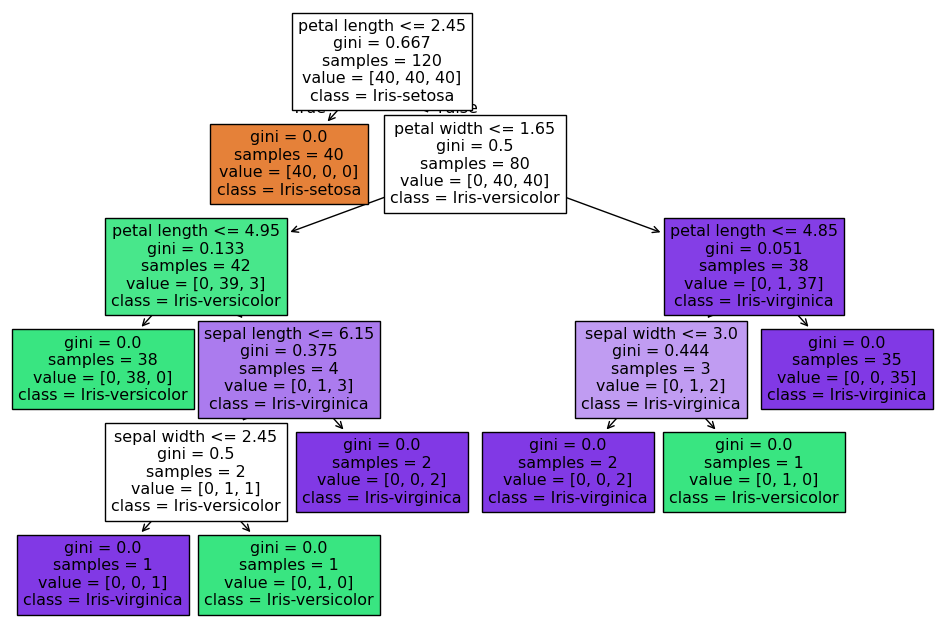

DTfeature importances:
 petal length    0.558568
petal width     0.406015
sepal width     0.029167
sepal length    0.006250
dtype: float64


In [ ]:
#decision tree classsifier


# train
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# eval
y_pred = clf.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"precision (macro): {precision_score(y_test, y_pred, average='macro'):.3f}")
print(f"recall (macro): {recall_score(y_test, y_pred, average='macro'):.3f}")

# visualization of each level of decision tree
plt.figure(figsize=(12,8))
tree.plot_tree(clf, feature_names=X.columns, class_names=sorted(y1d.unique()), filled=True)
plt.show()

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("DTfeature importances:\n", importances)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# random forrest classsifier

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

#  metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
print(f"Accuracy: {acc:.3f} | Precision (macro): {prec:.3f} | Recall (macro): {rec:.3f}")


print(classification_report(y_test, y_pred))


# feature importances with names
importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("feat importances:\n", importances)

#  10-fold CV with accuracy/precision/recall for hte later question
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(
    rf_clf, X, y1d, cv=cv,
    scoring={"acc":"accuracy","prec":"precision_macro","rec":"recall_macro"},n_jobs=-1, return_train_score=False)



Accuracy: 0.900 | Precision (macro): 0.902 | Recall (macro): 0.900
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.82      0.90      0.86        10
           2       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

feat importances:
 petal length    0.453793
petal width     0.412449
sepal length    0.115873
sepal width     0.017885
dtype: float64


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# base learner
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
adaboost = AdaBoostClassifier(estimator=stump, n_estimators=50,learning_rate=1.0, algorithm="SAMME",random_state=42)


# evaluate / fit
adaboost.fit(X_train, y_train)
y_pred = adaboost.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


accuracy: 0.9333
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rows = []
for k in range(1, 16, 2):
    knn = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=k))])

    # fit on train | evaluate on test
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    print(f"k={k} | Test  Acc: {acc:.3f} | Prec(m): {prec:.3f} | Rec(m): {rec:.3f}")

    # 10-fold CV on  data
    scores = cross_validate(
        knn, X, y_enc, cv=cv,
        scoring={"acc":"accuracy", "prec":"precision_macro", "rec":"recall_macro"}, n_jobs=-1, return_train_score=False)


    cv_acc  = scores["test_acc"].mean()
    cv_prec = scores["test_prec"].mean()
    cv_rec  = scores["test_rec"].mean()

    rows.append([k, acc, prec, rec, cv_acc, cv_prec, cv_rec])

# summary table
results_df = pd.DataFrame(rows, columns=[
    "k", "test_acc", "test_prec", "test_rec", "cv_acc", "cv_prec", "cv_rec"]).sort_values(["cv_acc","test_acc"], ascending=False)

print("\nsummary (sorted by CV accuracy..):\n", results_df)

# pick best k by CV accuracy
best_row = results_df.sort_values(
    ["cv_acc", "test_acc", "k"], ascending=[False, False, True]).iloc[0]

best_k = int(best_row["k"])
print(f"\nbest k by CV accuracy: {best_k} "
      f"(CV acc={best_row['cv_acc']:.3f}, test Acc={best_row['test_acc']:.3f})")


k=1 | Test  Acc: 0.967 | Prec(m): 0.970 | Rec(m): 0.967
k=3 | Test  Acc: 0.933 | Prec(m): 0.944 | Rec(m): 0.933
k=5 | Test  Acc: 0.933 | Prec(m): 0.944 | Rec(m): 0.933
k=7 | Test  Acc: 0.967 | Prec(m): 0.970 | Rec(m): 0.967
k=9 | Test  Acc: 0.967 | Prec(m): 0.970 | Rec(m): 0.967
k=11 | Test  Acc: 0.967 | Prec(m): 0.970 | Rec(m): 0.967
k=13 | Test  Acc: 0.967 | Prec(m): 0.970 | Rec(m): 0.967
k=15 | Test  Acc: 0.967 | Prec(m): 0.970 | Rec(m): 0.967

Summary (sorted by CV accuracy):
     k  test_acc  test_prec  test_rec    cv_acc   cv_prec    cv_rec
6  13  0.966667   0.969697  0.966667  0.973333  0.977778  0.973333
7  15  0.966667   0.969697  0.966667  0.960000  0.966032  0.960000
2   5  0.933333   0.944444  0.933333  0.960000  0.969841  0.960000
3   7  0.966667   0.969697  0.966667  0.960000  0.968254  0.960000
5  11  0.966667   0.969697  0.966667  0.960000  0.969841  0.960000
4   9  0.966667   0.969697  0.966667  0.953333  0.964286  0.953333
1   3  0.933333   0.944444  0.933333  0.94666

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


# SVM with scaling
svm_clf = Pipeline([("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42))])

# fit / predict
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# evaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)

print(f"accuracy: {acc:.3f} | Precision (macro): {prec:.3f} | Recall (macro): {rec:.3f}")
print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.967 | Precision (macro): 0.970 | Recall (macro): 0.967
Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
Classification report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



In [ ]:
#MLP
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import  confusion_matrix

#  scale to MLP
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),   # two layers
        activation="relu",
        solver="adam",
        alpha=1e-3,
        learning_rate="adaptive",
        max_iter=500,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42))
])

# fit / evaluate
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("report:\n", classification_report(y_test, y_pred))

accuracy: 0.6666666666666666
confusion matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0 10  0]]
report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.50      1.00      0.67        10
           2       0.00      0.00      0.00        10

    accuracy                           0.67        30
   macro avg       0.50      0.67      0.56        30
weighted avg       0.50      0.67      0.56        30



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarn

In [ ]:
#Naive Baye
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(var_smoothing=1e-9)
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred))
print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9666666666666667
Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



## Reflection questions:
- What is the best K in KNN? Only consider k in the range of 1-15. Use odd numbers only.
The best vlaue for K is 3, 5 and 9 performed the best with perfect accuracy. Other vlaues of K are close but not as high as those three.

- What is the most important features found by decision tree and random forest?
from randmforrest the most important feature is: `pedal` and for hte decision tree the most important feature is `pedal length` with the width following in both.

- Which algorithm has the highest accuracy? Is there model overfitting for this algorithm? Why or why not?Perform 10-fold cross-validation with this algorithm and report the accuracy, precision and recall.

the model with the highest accruacy was the Knearest neighbors model with K = (3, 5 and 9) all achieving perfect accuracy (no 10-fold validation yet), yes there was some over fitting but not too much, after performing the 10-fold CV the model achieved `CV Acc=0.973, Test Acc=0.967` these results are close to the origional output. see below for log table or all is avaible at the code block above.

Output logs for both vlaues of k after 10-fold CV:

` k  test_acc  test_prec  test_rec    cv_acc   cv_prec    cv_rec`

`6  13  0.966667   0.969697  0.966667  0.973333  0.977778  0.973333`

`7  15  0.966667   0.969697  0.966667  0.960000  0.966032  0.960000`
